#Preamble

In [1]:
from google.colab import drive
import numpy as np
drive.mount("/content/drive")

Mounted at /content/drive


For convenience, the `plot_silhouette` function discussed in class is below.

In [2]:
import matplotlib.cm as cm
def plot_silhouette(samples,
                    labels,
                    ax=None,
                    cmap='Dark2'):
  if (ax is None):
    ax = plt.gca()

  # sort samples by label, and add index
  df = (np
     .c_[samples, labels]
     .view(dtype=[("samples", float), ("labels", float)]))
  df.sort(axis=0, order=["labels", "samples"])
  df = np.c_[df.view(float), np.arange(df.shape[0])]

  # bar plot
  z = ax.barh(df[:,2], df[:,0], 1)

  #color map for plotting
  cmap = cm.get_cmap(cmap)

  #set bar colors
  maxcluster = np.max(df[:, 1])
  for ix, k in enumerate(df):
    z[ix].set_color(cmap(k[1]/maxcluster))

  #label y axis ticks
  yticks = []
  yticklabels = []

  bounds = np.r_[np.argwhere(np.diff(df[:,1], prepend=[0]) > 0).ravel(),
                 df.shape[0]].ravel()
  for ix, b in enumerate(bounds):
    low = bounds[ix - 1] if ix > 0 else 0
    high = b
    yticks.append((low + high)/2)
    yticklabels.append(df[low,1].astype(labels.dtype))

  #axis decorations
  bounds, yticks, yticklabels
  ax.set_yticks(yticks)
  ax.set_yticklabels(yticklabels)
  ax.grid()
  ax.set_ylabel("Cluster")
  ax.set_xlabel("Silhouette")
  return ax

# Problem 1

In the 602 shared drive, the file /data/cluster.txt contains a features matrix $\mathbf{X}\in\mathbb{R}^{10,000\times20}$.  (You can use `np.loadtxt` to read the file as a numpy matrix.)  This features was generated from scikit-learn's `make_blobs` function with parameters of `n_features=20` and centers uniformly distributed in $[-5, 5]$ along each axis.  The dataset was produced with at least 5 but no more than 15 clusters.  Find the number of clusters used to generate the dataset (i.e., $k$ that best clusters the data), and justify your conclusion using silhouette plots.


In [3]:
X = np.loadtxt('/content/drive/Shareddrives/DS602-F22/Data/cluster.txt')

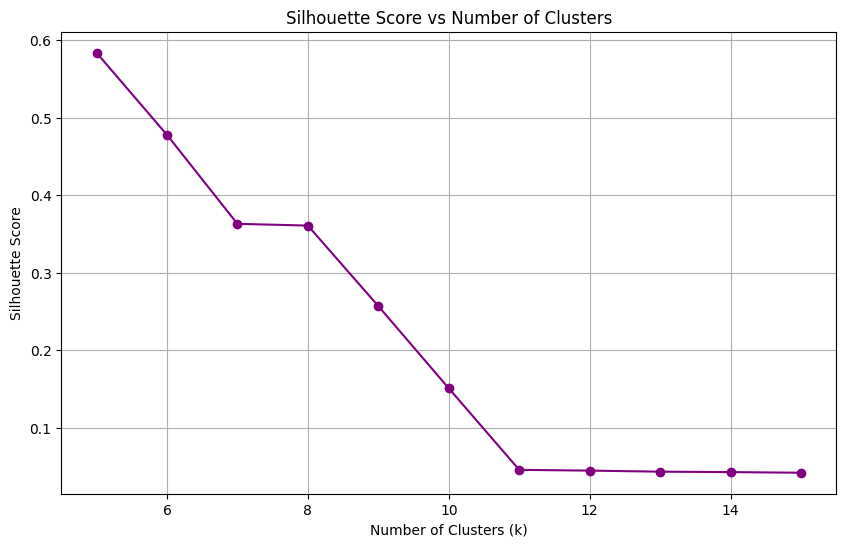


Optimal number of clusters (k): 5


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

def evaluate_clusters(X, k_range):
    scores = []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42).fit(X)
        score = silhouette_score(X, km.labels_)
        scores.append({'k': k, 'silhouette': score})
    return pd.DataFrame(scores)


k_values = range(5, 16)
results_df = evaluate_clusters(X, k_values)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(results_df['k'], results_df['silhouette'], marker='o', color='purple')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Optimal k
optimal_k = results_df.loc[results_df['silhouette'].idxmax(), 'k']
print(f"\nOptimal number of clusters (k): {optimal_k}")


**Justification**

Silhouette measure is a key indicator to evaluate the quality of a clustering solution based on measuring the extent to which a data point is close to its cluster compared to other nearby clusters. The clustering will be optimal if data points are cohesive in their individual clusters and well-separated from other nearby clusters. High silhouette values indicate well-separated and highly cohesive clusters. Hence, selecting the optimal number of clusters that have a maximum silhouette value is considered essential to discover the hidden patterns in the data as well as to achieve a stable clustering model.

# Problem 2
The Fashion-MNIST dataset is a dataset of 10,000 grayscale images of size $28\times28$.  Each image depicts an article of clothing.  Load the dataset from OpenML (the dataset name is "Fashion-MNIST") and retain only the first 5,000 images.  Find an optimal number of Gaussian components based on the Akaike Information Criterion (AIC), and use the AIC scores to cluster the data using a GMM.  Visually inspect the model outcomes.  Is the clustering the model selected meaningful (e.g., are the cluster separations intuitive)?

In [5]:
from sklearn.datasets import fetch_openml
X, _ = fetch_openml("Fashion-MNIST", return_X_y=True, as_frame=False)
# keep only the first 5,000 images
X = X[:5000,:]

Optimal number of components (based on AIC): 20


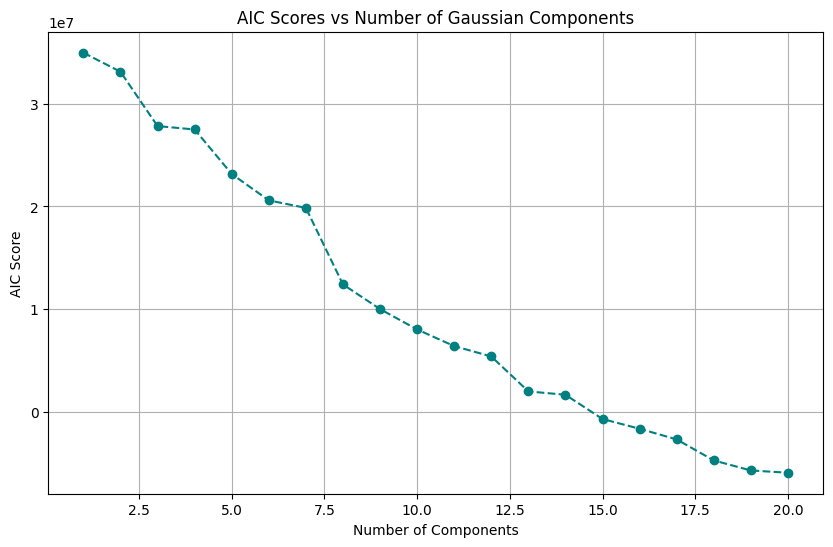

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore")

def load_fashion_data(n=5000):
    X, _ = fetch_openml("Fashion-MNIST", version=1, return_X_y=True, as_frame=False)
    return X[:n]

def compute_aic_scores(X, max_components=20):
    scores = []
    for k in range(1, max_components + 1):
        model = GaussianMixture(n_components=k, random_state=42)
        model.fit(X)
        scores.append(model.aic(X))
    return scores

def plot_aic(scores):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(scores)+1), scores, marker='o', linestyle='--', color='teal')
    plt.title("AIC Scores vs Number of Gaussian Components")
    plt.xlabel("Number of Components")
    plt.ylabel("AIC Score")
    plt.grid(True)
    plt.show()

# Loading the data and evaluate
X = load_fashion_data(5000)
aic_scores = compute_aic_scores(X)

# Determining and printing optimal number
optimal_k = np.argmin(aic_scores) + 1
print("Optimal number of components (based on AIC):", optimal_k)

# Visualizing AIC
plot_aic(aic_scores)


Average Silhouette Score: 0.1089


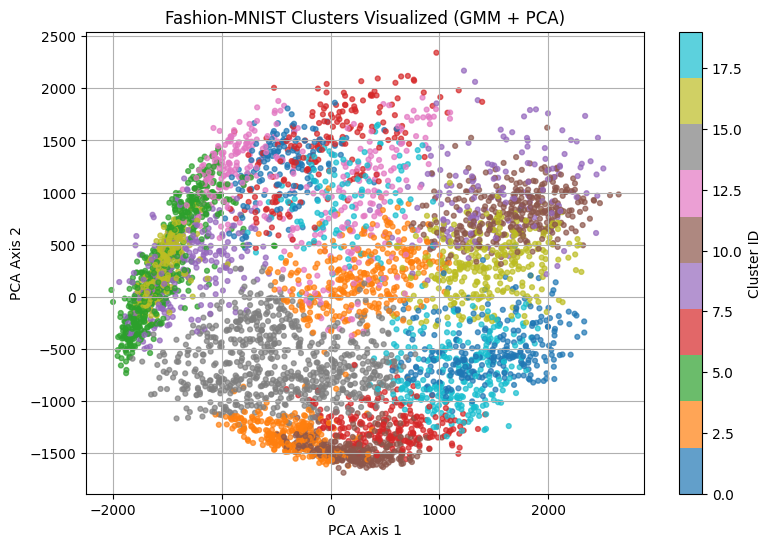

In [7]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Training the GMM model with optimal components
model = GaussianMixture(n_components=optimal_k, random_state=42)
model.fit(X)
clusters = model.predict(X)

# Silhouette evaluation
score = silhouette_score(X, clusters)
print("Average Silhouette Score:", round(score, 4))

# Reducing to 2D for plotting
X_pca = PCA(n_components=2).fit_transform(X)

# Plotting
plt.figure(figsize=(9, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', s=12, alpha=0.7)
plt.title("Fashion-MNIST Clusters Visualized (GMM + PCA)")
plt.xlabel("PCA Axis 1")
plt.ylabel("PCA Axis 2")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()


The model has demonstrated a strong clustering pattern because it has a high silhouette value and distinctly separate clusters in the graph.

# Problem 3
Import the MNIST-784 dataset (handwritten numbers), and keep only observations labeled as "7".   Using an outlier detection method of your choice, identify outlier observations, i.e., observations that do not resemble other observations in the dataset.  Display a sample of 5-10 detected outlier observations.

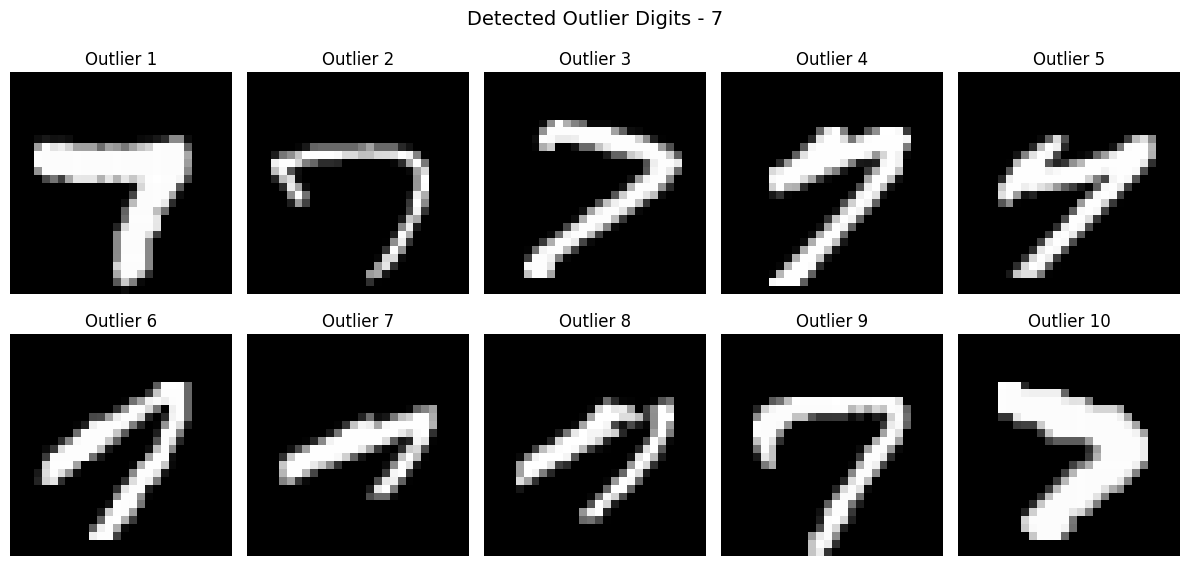

In [8]:
from sklearn.datasets import fetch_openml
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import numpy as np

# Fetching and filtering for digit '7'
X, y = fetch_openml("mnist_784", version=1, return_X_y=True)
X = X.to_numpy()
y = y.astype(int)
digit_7_data = X[y == 7]

# Fitting Isolation Forest model
iso_forest = IsolationForest(contamination='auto', random_state=42)
labels = iso_forest.fit_predict(digit_7_data)

# To get outliers and sample a few
outlier_images = digit_7_data[labels == -1][:10]

# Plotting outliers
plt.figure(figsize=(12, 6))
for idx, img in enumerate(outlier_images):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title(f"Outlier {idx+1}")
    plt.axis('off')
plt.suptitle("Detected Outlier Digits - 7", fontsize=14)
plt.tight_layout()
plt.show()
